In [12]:
!pip install ptitprince

In [18]:
''' IMPORTS '''
import math
import numpy as np
import random
from numpy.random import beta as Beta
from matplotlib import pyplot as plt
import ptitprince as pt
import pandas as pd

In [103]:
''' SIMULATOR '''
def get_shape_params(mean, var):
  a = -(mean*(var+mean**2-mean)) / var
  b = ((var + mean**2-mean)*(mean-1)) / var
  return (max(0.0000001,a), max(0.0000001,b)) ## make sure that a and b are positive

def get_variance(a, b):
  return (a*b) / ((a+b)**2 * (a+b+1))

def get_mean(a, b):
  return a / (a+b)

class JudgingSimulator:
  def __init__(self, expected_team_values, n_judges, opinion_var=0.02, eval_var=0.02):
    self.n_judges = n_judges
    self.eval_var = eval_var
    self.n_teams = len(expected_team_values)
    self.team_value_shapes = [get_shape_params(val, opinion_var)
                              for val in expected_team_values]

    def _get_judge_opinions():
      # sample a judge's opinion of each team
      return [Beta(*value_shape) for value_shape in self.team_value_shapes]

    self.judges_opinions = [_get_judge_opinions() for _ in range(n_judges)]

  def judge(self, judge, team1, team2):
    # judge is the index of the judge we are querying
    # team1, team2 are the index of the two teams to compare
    # return the index of the team that wins
    eval1, eval2 = self.sample_evaluations(judge, [team1, team2])
    return team1 if eval1 > eval2 else team2

  def sample_evaluations(self, judge, teams=None):
    teams = teams or np.arange(self.n_teams)
    opinions = [self.judges_opinions[judge][team] for team in teams]
    eval_shapes = [get_shape_params(opinion, self.eval_var) for opinion in opinions]
    evals = [Beta(*eval_shape) for eval_shape in eval_shapes]
    return evals



Text(0.5, 0, 'q-values')

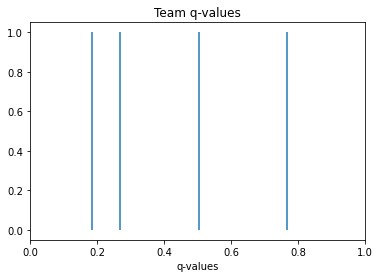

In [106]:
def get_qvalues(var_team, n_teams):
    a = 1 - np.sqrt(12 * var_team)
    return np.random.uniform(a, 0.9, n_teams)

var_team = 1/15
qs = get_qvalues(var_team = var_team, n_teams = 4)
plt.vlines(qs, 0, 1)
plt.xlim(0, 1)
plt.title('Team q-values')
plt.xlabel('q-values')

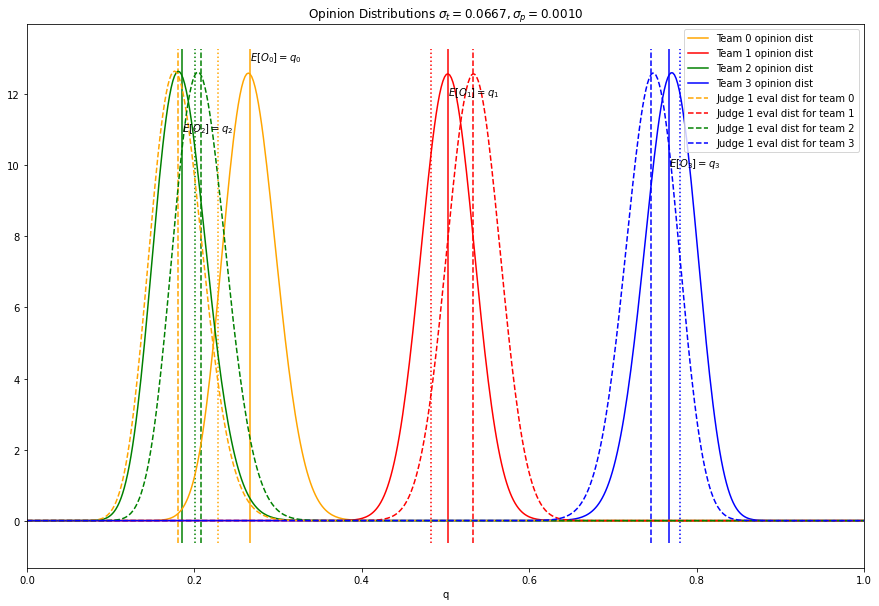

In [132]:
import scipy.stats as ss

plt.figure(figsize=(15, 10))

def plot_beta(a=2, b=2, **kwargs):
    x = np.linspace(0, 1, 500)
    y = ss.beta.pdf(x, a, b)
    plt.plot(x, y, **kwargs)

opinion_var=0.001
sim = JudgingSimulator(qs, n_judges=1, opinion_var=opinion_var, eval_var=0.001)

for i, (a, b) in enumerate(sim.team_value_shapes):
    plot_beta(a, b, c=colors[i], label=f'Team {i} opinion dist')

colors = ['orange', 'red', 'green', 'blue']

ylims = plt.ylim()
plt.vlines(qs, *ylims, color=colors, linestyles='-')
plt.xlim(0, 1)
plt.title(f'Opinion Distributions $\sigma_t={var_team:.4f}, \sigma_p={opinion_var:.4f}$')
plt.xlabel('q')

for i, q in enumerate(qs):
    plt.text(q, plt.ylim()[1]-1-i, f'$E[O_{i}]=q_{i}$')

for judge_opinions in sim.judges_opinions:
    plt.vlines(judge_opinions, *ylims, color=colors, linestyles='--')
    
for i, opinion in enumerate(judge_opinions):
    a, b = get_shape_params(opinion, sim.eval_var)
    plot_beta(a, b, c=colors[i], linestyle='--', label=f'Judge 1 eval dist for team {i}')

plt.vlines(sim.sample_evaluations(0), *ylims, color=colors, linestyles='dotted')

plt.legend()

In [ ]:
# opinion_dist = np.array([[Beta(*value_shape) for value_shape in sim.team_value_shapes] for _ in range(1000)])
# df = pd.DataFrame(opinion_dist).rename_axis("team", axis="columns").rename_axis("idx", axis="index")
# df = df.stack().reset_index(level=[0,1]).rename(columns={0: 'q'})

# # Changing orientation
# dx="team"; dy="q"; ort="v"; pal = "Set2"; sigma = .2
# f, ax = plt.subplots(figsize=(14, 10))

# pt.RainCloud(x = dx, y = dy, data = df, palette = pal, bw = sigma,
#                  width_viol = .5, ax = ax, orient = ort)
